In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings

warnings.filterwarnings('ignore')

In [2]:
sales_data = pd.read_csv(r'C:\Users\amank\OneDrive\Desktop\Car_Forcasting\data\processed_data\sales_data_clean.csv')

# Final Model For All Sales Counts

16:12:47 - cmdstanpy - INFO - Chain [1] start processing
16:12:47 - cmdstanpy - INFO - Chain [1] done processing


                   yhat
ds                     
2024-02-29  1104.435277
2024-03-31  1483.778740
2024-04-30  1319.260391
2024-05-31   728.780711
2024-06-30   998.917081
2024-07-31  1177.482876
2024-08-31  1162.468176
2024-09-30  1390.205014
2024-10-31  1211.752441
2024-11-30   957.915360
2024-12-31   765.742222
2025-01-31  1115.069710


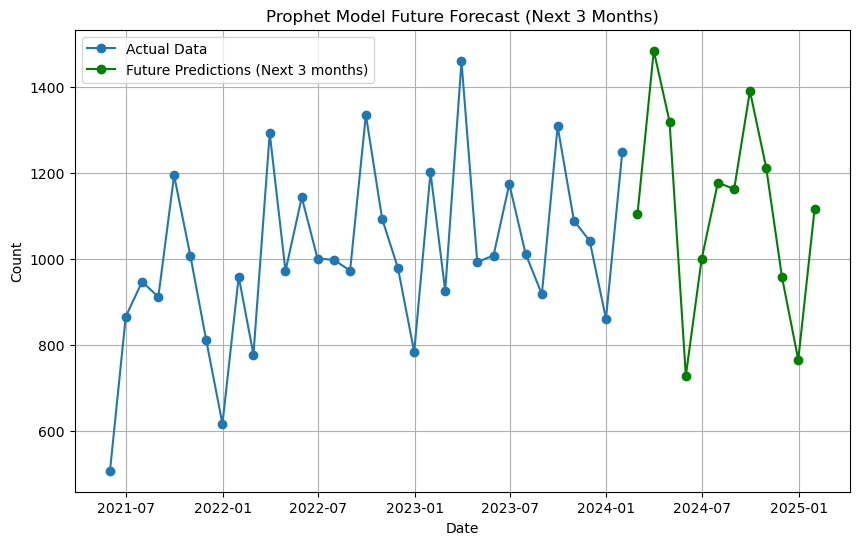

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Ensure the index is a datetime type and prepare data for Prophet
data = sales_data.INVOICEDAT.value_counts().reset_index().sort_values(by='INVOICEDAT').reset_index(drop=True)
data = data.set_index('INVOICEDAT')
data.index = pd.to_datetime(data.index)

# Convert the data to monthly frequency and sum values within each month
data = data.resample('M').sum()

# Prophet requires columns named 'ds' (datetime) and 'y' (target variable)
data_prophet = data.reset_index().rename(columns={'INVOICEDAT': 'ds', 'count': 'y'})

# Handle missing values
data_prophet['y'] = data_prophet['y'].fillna(0)  # Or use forward fill, interpolation, etc.

# Initialize the Prophet model with tuned parameters
model = Prophet(
    yearly_seasonality=True,  # Enable yearly seasonality
    weekly_seasonality=False,  # Disable weekly seasonality if not needed
    daily_seasonality=False,   # Disable daily seasonality if not needed
    changepoint_prior_scale=0.1,  # Adjust to control sensitivity to changepoints
    seasonality_prior_scale=5.0,  # Adjust to control seasonality sensitivity
    holidays_prior_scale=0.1,  # Control for holidays
    interval_width=0.95  # Adjust uncertainty intervals
)

# Optionally add holidays
# holidays = pd.DataFrame({
#     'holiday': 'my_holiday',
#     'ds': pd.to_datetime(['2024-12-25', '2024-01-01']),  # Add your holiday dates
#     'lower_window': 0,
#     'upper_window': 1,
# })
# model = Prophet(holidays=holidays)

# Fit the model on the entire dataset
model.fit(data_prophet)

# Forecast for the next three months (monthly frequency)
future_steps = 12
future_dates = model.make_future_dataframe(periods=future_steps, freq='M')  # Monthly frequency
future_forecast = model.predict(future_dates)

# Get future predictions
future_predictions = future_forecast[['ds', 'yhat']].set_index('ds').iloc[-future_steps:]
print(future_predictions)

# Optional: Plot the future forecast
plt.figure(figsize=(10, 6))
# Plot the actual data
plt.plot(data_prophet['ds'], data_prophet['y'], label='Actual Data', marker='o')
# Plot future forecast
plt.plot(future_predictions.index, future_predictions['yhat'], label='Future Predictions (Next 3 months)', color='g', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Prophet Model Future Forecast (Next 3 Months)')

# Legend and grid
plt.legend()
plt.grid()
plt.show()


In [42]:
future_predictions = future_predictions.astype(int).reset_index().rename(columns={'ds': 'Date', 'yhat' : 'Predictions'})
future_predictions.to_csv(r'C:\Users\amank\OneDrive\Desktop\Car_Forcasting\results\Total_counts_pred.csv', index=False)
future_predictions

,Date,Predictions
0,2024-02-29,1104
1,2024-03-31,1483
2,2024-04-30,1319
3,2024-05-31,728
4,2024-06-30,998
5,2024-07-31,1177
6,2024-08-31,1162
7,2024-09-30,1390
8,2024-10-31,1211
9,2024-11-30,957


# Final Model of Make Model

In [23]:
import pandas as pd
from prophet import Prophet
import numpy as np

# Convert your data's date column to datetime
sales_data['INVOICEDAT'] = pd.to_datetime(sales_data['INVOICEDAT'])

# Set the forecast period to 90 days (approximately three months)
forecast_period = 365
monthly_forecasts = {}

# Loop through each unique make
for make in sales_data['Make_new'].unique():
    # Filter data for the current make and aggregate to daily frequency
    make_data = sales_data[sales_data['Make_new'] == make]
    make_daily = make_data.groupby('INVOICEDAT').size().reset_index(name='y')
    make_daily = make_daily.rename(columns={'INVOICEDAT': 'ds'})
    
    # Check if there are at least two valid rows
    if make_daily['y'].count() < 2:
        print(f"Skipping '{make}' due to insufficient data.")
        continue
    
    # Initialize and fit Prophet model with easy tuning
    model = Prophet(
        yearly_seasonality=True,  # Keep yearly seasonality if applicable
        weekly_seasonality=False,  # Disable weekly seasonality
        daily_seasonality=False,   # Disable daily seasonality
        changepoint_prior_scale=0.1  # Lower sensitivity to changepoints
    )
    model.fit(make_daily)
    
    # Generate future dates for 3 months (90 days)
    future = model.make_future_dataframe(periods=forecast_period)
    forecast = model.predict(future)
    
    # Filter forecast for the next three months only
    forecast['month'] = forecast['ds'].dt.to_period('M')  # Extract month from date
    next_three_months = forecast[forecast['ds'] > make_daily['ds'].max()].groupby('month')['yhat'].sum().head(12)
    
    # Store results for each make in dictionary
    monthly_forecasts[make] = next_three_months.values

# Convert the dictionary into a DataFrame with each row as a make and columns as months
forecast_make_df = pd.DataFrame.from_dict(
    monthly_forecasts, 
    orient='index', 
    columns=next_three_months.reset_index()['month']
).reset_index().rename(columns={'index': 'Make'})

forecast_make_df

16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing
16:03:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing
16:03:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:36 - cmdstanpy - INFO - Chain [1] done processing
16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:37 - cmdstanpy - INFO - Chain [1] done processing
16:03:37 - cmdstanpy - INFO - Chain [1] start processing
16:03:37 - cmdstanpy - INFO - Chain [1] done processing
16:03:38 - cmdstanpy - INFO - Chain [1] start processing
16:03:38 - cmdstanpy - INFO - Chain [1] done processing
16:03:38 - cmdstanpy - INFO - Chain [1] start processing
16:03:38 - cmdstanpy - INFO - Chain [1] done processing
16:03:39 - cmdstanpy - INFO - Chain [1] start processing
16:03:39 - cmdstanpy - INFO - Chain [1]

Skipping 'nan' due to insufficient data.


16:03:49 - cmdstanpy - INFO - Chain [1] done processing


month,Make,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,ford,939.725720,1149.950609,891.675531,886.834767,938.613718,923.291092,966.964805,1130.920769,1011.708904,879.845310,760.208033,871.882087
1,Other,58.763832,60.135423,52.618980,62.944655,60.380572,60.575330,58.206912,59.007095,46.922686,56.881863,48.260695,57.554346
2,volvo,42.727515,39.747959,36.063790,46.153411,40.048076,48.228431,45.270102,43.135927,39.241738,40.480685,44.568739,46.993422
3,fiat,2.003265,43.971053,45.343667,35.221496,37.272313,34.361157,35.942287,39.575617,41.313870,36.018867,35.544466,34.283086
4,seat,46.851808,45.740117,40.218229,50.703394,48.164472,51.717801,46.053516,45.387074,52.047329,47.426820,48.873656,40.251819
5,mini,44.635278,52.509657,32.435782,36.647078,45.824005,37.225200,38.047256,34.351872,40.031706,39.404700,32.956564,43.390543
6,vauxhall,77.571721,67.817694,79.722097,84.307722,86.363684,85.921034,82.421108,81.747936,85.462443,76.789775,62.438790,84.339372
7,renault,41.971271,39.732357,45.070272,38.850875,39.680271,44.736311,41.231075,44.667545,45.542202,43.250241,39.497846,45.163378
8,mitsubishi,1.187281,34.798487,41.808882,36.856775,40.817880,36.328384,36.952116,42.961855,43.191437,38.532338,33.269928,40.589067
9,nissan,61.088862,54.876899,47.568245,56.210281,64.767050,50.866949,51.399564,42.694720,58.441328,47.287238,64.097334,57.195679


In [44]:
forecast_make_df = forecast_make_df.set_index('Make').astype(int).reset_index()
forecast_make_df.to_csv(r'C:\Users\amank\OneDrive\Desktop\Car_Forcasting\results\Make_pred.csv', index=False)

# Final Model For Vehicle Model

In [183]:
import pandas as pd
from prophet import Prophet
import numpy as np

# Convert the date column to datetime format if not already
sales_data['INVOICEDAT'] = pd.to_datetime(sales_data['INVOICEDAT'])

# Forecasting settings
forecast_period = 365  # Forecast for 90 days (approximately 3 months)
monthly_forecasts = {}

# Iterate over each unique model in the 'Model_new' column
for model_name in sales_data['Model_new'].unique():
    # Filter and aggregate data for the current model to daily frequency
    model_data = sales_data[sales_data['Model_new'] == model_name]
    daily_data = model_data.groupby('INVOICEDAT').size().reset_index(name='y')
    daily_data = daily_data.rename(columns={'INVOICEDAT': 'ds'})

    # Check if there's enough data to fit the Prophet model
    if len(daily_data) < 2:
        print(f"Skipping '{model_name}' due to insufficient data.")
        continue

    # Initialize and fit the Prophet model with seasonality adjustments
    prophet_model = Prophet()
    prophet_model.fit(daily_data)

    # Create future dates and generate forecast
    future_dates = prophet_model.make_future_dataframe(periods=forecast_period)
    forecast = prophet_model.predict(future_dates)

    # Filter forecast results to the next three months only
    forecast['month'] = forecast['ds'].dt.to_period('M')
    last_date = daily_data['ds'].max()
    forecast_next_three_months = forecast[forecast['ds'] > last_date].groupby('month')['yhat'].sum().head(12)

    # Store forecasted monthly results for the current model
    monthly_forecasts[model_name] = forecast_next_three_months.values

# Create a DataFrame from the forecast dictionary
forecast_model_df = pd.DataFrame.from_dict(
    monthly_forecasts, 
    orient='index', 
    columns=forecast_next_three_months.reset_index()['month']
).reset_index().rename(columns={'index': 'Model'})

forecast_model_df

15:57:15 - cmdstanpy - INFO - Chain [1] start processing
15:57:15 - cmdstanpy - INFO - Chain [1] done processing
15:57:16 - cmdstanpy - INFO - Chain [1] start processing
15:57:17 - cmdstanpy - INFO - Chain [1] done processing
15:57:17 - cmdstanpy - INFO - Chain [1] start processing
15:57:18 - cmdstanpy - INFO - Chain [1] done processing
15:57:18 - cmdstanpy - INFO - Chain [1] start processing
15:57:19 - cmdstanpy - INFO - Chain [1] done processing
15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:20 - cmdstanpy - INFO - Chain [1] done processing
15:57:20 - cmdstanpy - INFO - Chain [1] start processing
15:57:21 - cmdstanpy - INFO - Chain [1] done processing
15:57:21 - cmdstanpy - INFO - Chain [1] start processing
15:57:22 - cmdstanpy - INFO - Chain [1] done processing
15:57:22 - cmdstanpy - INFO - Chain [1] start processing
15:57:23 - cmdstanpy - INFO - Chain [1] done processing
15:57:23 - cmdstanpy - INFO - Chain [1] start processing
15:57:23 - cmdstanpy - INFO - Chain [1]

Skipping 'nan' due to insufficient data.


15:57:35 - cmdstanpy - INFO - Chain [1] start processing
15:57:35 - cmdstanpy - INFO - Chain [1] done processing
15:57:36 - cmdstanpy - INFO - Chain [1] start processing
15:57:36 - cmdstanpy - INFO - Chain [1] done processing
15:57:37 - cmdstanpy - INFO - Chain [1] start processing
15:57:37 - cmdstanpy - INFO - Chain [1] done processing
15:57:37 - cmdstanpy - INFO - Chain [1] start processing
15:57:38 - cmdstanpy - INFO - Chain [1] done processing
15:57:39 - cmdstanpy - INFO - Chain [1] start processing
15:57:39 - cmdstanpy - INFO - Chain [1] done processing
15:57:40 - cmdstanpy - INFO - Chain [1] start processing
15:57:40 - cmdstanpy - INFO - Chain [1] done processing
15:57:41 - cmdstanpy - INFO - Chain [1] start processing
15:57:41 - cmdstanpy - INFO - Chain [1] done processing
15:57:42 - cmdstanpy - INFO - Chain [1] start processing
15:57:42 - cmdstanpy - INFO - Chain [1] done processing
15:57:43 - cmdstanpy - INFO - Chain [1] start processing
15:57:43 - cmdstanpy - INFO - Chain [1]

month,Model,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,Ford Transit Variants,78.397440,115.939107,97.577369,95.222077,66.409956,90.049800,69.212159,111.637880,122.163878,77.239180,44.292106,55.902918
1,Ford Focus Variants,146.594865,149.972850,123.103743,121.237328,103.738711,106.962439,119.481685,133.056191,143.691948,118.940841,94.695529,127.164854
2,ecosport,4.441672,30.936510,46.111090,50.183829,29.427543,25.647083,27.358200,22.749236,30.539576,31.719889,19.044292,17.178818
3,Ford Fiesta Variants,176.365437,203.651098,168.047235,154.314502,176.056687,177.095068,193.345000,229.880066,193.293743,124.618138,86.305238,141.681428
4,Ford Kuga Variants,129.421737,163.767645,135.660415,144.516557,130.829794,136.870398,120.453045,147.787714,124.330046,116.557977,107.536125,132.711371
5,s-max,48.162803,32.556564,32.434590,37.836763,42.520516,35.518452,38.506028,40.089187,35.693706,37.899033,38.947467,42.550641
6,Ford Ranger Variants,70.373527,83.922783,68.391924,74.837372,77.515859,68.838799,59.329471,73.931831,69.559531,65.888530,79.288316,84.378561
7,Other,198.932058,216.673738,191.628538,222.625469,202.958968,228.459611,237.067220,234.532148,241.023636,231.525279,231.378287,283.788515
8,c-max,1.157377,34.170650,38.264314,35.949528,37.873726,43.910025,37.806598,34.429912,37.688187,40.158898,40.778125,37.508056
9,Ford Mondeo Variants,35.118914,48.086474,38.740312,43.599938,34.086051,37.721476,42.692963,31.787761,40.195083,36.659953,32.871494,38.724668


In [164]:
# Merge DataFrames on the Model column
forecast_model_df = forecast_model_df.set_index('Model').astype(int).reset_index()

# Merging the DataFrames
df = forecast_model_df.merge(
    sales_data[['Make_new', 'Model_new']],
    left_on='Model',
    right_on='Model_new',
    how='left'
).drop_duplicates().drop('Model_new', axis=1).reset_index(drop=True)

# Reorder columns
new_column_order = ['Make_new', 'Model'] + [col for col in df.columns if col not in ['Make_new', 'Model']]
df = df[new_column_order].reset_index(drop=True)

# Display the result
df.head()


,Make_new,Model,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,ford,Ford Transit Variants,78,115,97,95,66,90,69,111,122,77,44,55
1,ford,Ford Focus Variants,146,149,123,121,103,106,119,133,143,118,94,127
2,ford,ecosport,4,30,46,50,29,25,27,22,30,31,19,17
3,ford,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141
4,NaN,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141


In [121]:
forecast_model_df.head(10)

,Make,Model,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,ford,Ford Transit Variants,78,115,97,95,66,90,69,111,122,77,44,55
1,ford,Ford Focus Variants,146,149,123,121,103,106,119,133,143,118,94,127
2,ford,ecosport,4,30,46,50,29,25,27,22,30,31,19,17
3,ford,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141
4,NaN,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141
5,ford,Ford Kuga Variants,129,163,135,144,130,136,120,147,124,116,107,132
6,ford,s-max,48,32,32,37,42,35,38,40,35,37,38,42
7,ford,Ford Ranger Variants,70,83,68,74,77,68,59,73,69,65,79,84
8,NaN,Other,198,216,191,222,202,228,237,234,241,231,231,283
9,ford,c-max,1,34,38,35,37,43,37,34,37,40,40,37


In [122]:
forecast_model_df.loc[8, 'Make'] = 'others'
forecast_model_df.Make.fillna('ford', inplace=True)

In [126]:
forecast_model_df  = forecast_model_df.drop_duplicates()

In [149]:
df = forecast_model_df.merge(sales_data[['Make_new', 'Model_new']], left_on='Model'dd, right_on='Model_new', how='left').drop_duplicates().drop('Model_new', axis = 1).drop_duplicates().reset_index(drop = True)

In [168]:
df.loc[df['Model'] == 'Other', 'Make_new'] = 'Other' 

In [177]:
df = df.drop_duplicates()

In [175]:
df.Make_new.fillna('ford', inplace=True)
df.drop(42, axis = 0, inplace=True)

In [ ]:
df = df.drop_duplicates()

In [179]:
df.to_csv(r'C:\Users\amank\OneDrive\Desktop\Car_Forcasting\results\Model_pred.csv', index=False)

In [181]:
df

,Make_new,Model,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01
0,ford,Ford Transit Variants,78,115,97,95,66,90,69,111,122,77,44,55
1,ford,Ford Focus Variants,146,149,123,121,103,106,119,133,143,118,94,127
2,ford,ecosport,4,30,46,50,29,25,27,22,30,31,19,17
3,ford,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141
5,ford,Ford Kuga Variants,129,163,135,144,130,136,120,147,124,116,107,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,mini,countryman,1,18,15,11,19,20,18,17,13,19,11,13
84,ford,mach-e,4,16,20,16,16,17,25,24,34,26,21,31
85,ford,grand tourneo connect,2,13,24,22,22,21,25,29,23,26,17,29
86,mitsubishi,outlander,9,67,36,29,34,29,29,36,35,30,43,45


In [222]:
# Merging the DataFrames
df = forecast_model_df.merge(
    sales_data[['Make_new', 'Model_new']],
    left_on='Model',
    right_on='Model_new',
    how='left'
).drop_duplicates().drop('Model_new', axis=1).reset_index(drop=True)

# Reorder columns
new_column_order = ['Make_new', 'Model'] + [col for col in df.columns if col not in ['Make_new', 'Model']]
df = df[new_column_order].reset_index(drop=True)

df.loc[df['Model'] == 'Other', 'Make_new'] = 'Other' 


# forecast_model_df.loc[8, 'Make'] = 'others'
# forecast_model_df.Make.fillna('ford', inplace=True)
df.drop_duplicates(inplace=True)


# Display the result
df.head(50)

,Make_new,Model,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,Make
0,ford,Ford Transit Variants,78,115,97,95,66,90,69,111,122,77,44,55,ford
1,ford,Ford Focus Variants,146,149,123,121,103,106,119,133,143,118,94,127,ford
2,ford,ecosport,4,30,46,50,29,25,27,22,30,31,19,17,ford
3,ford,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141,ford
4,NaN,Ford Fiesta Variants,176,203,168,154,176,177,193,229,193,124,86,141,ford
5,ford,Ford Kuga Variants,129,163,135,144,130,136,120,147,124,116,107,132,ford
6,ford,s-max,48,32,32,37,42,35,38,40,35,37,38,42,ford
7,ford,Ford Ranger Variants,70,83,68,74,77,68,59,73,69,65,79,84,ford
8,Other,Other,198,216,191,222,202,228,237,234,241,231,231,283,ford
32,ford,c-max,1,34,38,35,37,43,37,34,37,40,40,37,others
